In [159]:
%matplotlib inline

In [160]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [174]:
def process_torch_log(logfname):
    train = {}
    test = {}
    
    import re
    trainp = re.compile('Epoch:\s+\[(\d+)\]\[(\d+)\/(\d+)\]\s+Time\s+(\d+\.\d+)\s+Err\s+(\d+\.\d+)\s+Top1\-\%\:\s+(\d+\.\d+)\s+LR\s+([\d|e|\.\-]+)\s+DataLoadingTime\s+(\d+\.\d+)*')
    testp = re.compile('Epoch:\s+\[(\d+)\]\[TESTING\s+SUMMARY\]\s+Total\s+Time\(s\):\s+(\d+\.\d+)\s+average\s+loss\s+\(per\s+batch\):\s+(\d+\.\d+)\s+accuracy\s+\[Center\]\(\%\):\s+top\-1\s+(\d+\.\d+)')
    #added top5 accuracy
    testpnew = re.compile('Epoch:\s+\[NEW\]\s*\[(\d+)\]\[TESTING\s+SUMMARY\]\s+Total\s+Time\(s\):\s+(\d+\.\d+)\s+average\s+loss\s+\(per\s+batch\):\s+(\d+\.\d+)\s+accuracy\s+\[Center\]\(\%\):\s+top\-1\s+(\d+\.\d+)\s+top\-5\s+(\d+\.\d+)')
    
    with open(logfname) as log:
        contents = log.readlines()
        print len(contents)," of log lines to process"
        iteration_logs = [ trainp.match(l) for l in contents if trainp.match(l)]
        test_logs = [testp.match(l) for l in contents if testp.match(l)]
        testnew_logs = [testpnew.match(l) for l in contents if testpnew.match(l)]
        print len(iteration_logs)," lines of iteration logs to process"
        print len(test_logs)," lines of of test logs to process"
        print len(testnew_logs)," lines of of [NEW] test logs to process"
        it = 0
        epoch = 0
        print "Start Processing Logs... "
        epochSize = 0
        for log in iteration_logs:
            #print log.groups()
            epoch,it,total_iters,time,err,top1,lr,loadt= [eval(n) for n in log.groups()]
            train[epoch] = train.get(epoch, {})
            epochSize = total_iters # should be same for all epochs
            train[epoch][it] = {'err':err,'lr':lr,'top1':top1}
            #train[epoch][1][it] = err
            #train[epoch][2][it] = lr
            #train[epoch][3][it] = top1
        if len(testnew_logs) != 0 :
            for log in testnew_logs:
                epoch,total_time,avg_loss,top1,top5 = [eval(n) for n in log.groups()]
                test[epoch] = test.get(epoch, {})
                test[epoch]['avg_loss'] = avg_loss
                test[epoch]['top1'] = top1
                test[epoch]['top5'] = top5
        else:
            if len(test_logs) == 0:
                print "no test logs found!"
            for log in test_logs:
                epoch,total_time,avg_loss,top1 = [eval(n) for n in log.groups()]
                test[epoch] = test.get(epoch, {})
                test[epoch]['avg_loss'] = avg_loss
                test[epoch]['top1'] = top1
                test[epoch]['top5'] = 0
        print "Done Log Processing."
        #prepare ndarrays for plotting, conform with caffe analyse result format
        train_tbl = np.zeros((3,len(train.keys()*epochSize))) #iter,trainloss3
        test_tbl = np.zeros((5,len(test.keys()))) #iter,lr,trainloss3,testtop1,testtop5
        test_tbl_epoch = np.zeros((5,len(test.keys())))
        #turn test into nd arrays and sync with caffe result tables
        idx_train = 0
        for epoch,epochData in sorted(train.items()):
            for iter,iterData in sorted(epochData.items()):
                train_tbl[0][idx_train] = (epoch-1)*epochSize + iter # calculate the global iteration
                train_tbl[1][idx_train] = iterData['lr']
                train_tbl[2][idx_train] = iterData['err']
                idx_train = idx_train + 1
        idx_test = 0
        for epoch,epochData in sorted(test.items()):
            test_tbl[0][idx_test] = epoch*epochSize
            test_tbl[1][idx_test] = train[epoch][epochSize]['lr']
            test_tbl[2][idx_test] = train[epoch][epochSize]['err'] # trainloss3
            test_tbl[3][idx_test] = epochData['top1']/100.0
            test_tbl[4][idx_test] = epochData['top5']/100.0 #top5
            test_tbl_epoch[0][idx_test] = epoch
            test_tbl_epoch[1][idx_test] = train[epoch][epochSize]['lr']
            test_tbl_epoch[2][idx_test] = train[epoch][epochSize]['err'] # ??=trainloss3
            test_tbl_epoch[3][idx_test] = epochData['top1']/100.0
            test_tbl_epoch[4][idx_test] = epochData['top5']/100.0 #top5
            idx_test = idx_test + 1
            #test_tbl[4][idx_test] = epochData['top5']
        #return the train, test results and the last epoch and last iteration
        return train_tbl[:,:idx_train],test_tbl[:,:idx_train],test_tbl_epoch[:,:idx_test],epoch,idx_train

In [210]:
#process the logs, specify the location of the log file here
tests = [
    #('512-triangular2','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU-triangular2.log'),
    ('512-original','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU.log'),
    #('128-original','/home/user/shane/soumith-imgnet-training/torch-yiheng-googlenetv2-bs128-8GPU.log'),
    ('512-triangular2-t2','/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU-triangular2-t2.log'),
    ]
result_tbls = []
for (label,log) in tests:
    print 'TEST ===',label,'==='
    print log
    train1,test1,test1_epoch,last_epoch,last_it = process_torch_log(log)
    result_tbls.append({'label':label,'train_result':train1,'test_result':test1,'test_result_epoch':test1_epoch,'last_epoch':last_epoch,'last_it':last_it})
    

TEST === 512-original ===
/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU.log
80166  of log lines to process
78650  lines of iteration logs to process
55  lines of of test logs to process
0  lines of of [NEW] test logs to process
Start Processing Logs... 
Done Log Processing.
TEST === 512-triangular2-t2 ===
/home/user/shane/soumith-imgnet-training/torch-googlenetv2-bs896-8GPU-triangular2-t2.log
1258  of log lines to process
665  lines of iteration logs to process
0  lines of of test logs to process
0  lines of of [NEW] test logs to process
Start Processing Logs... 
no test logs found!
Done Log Processing.


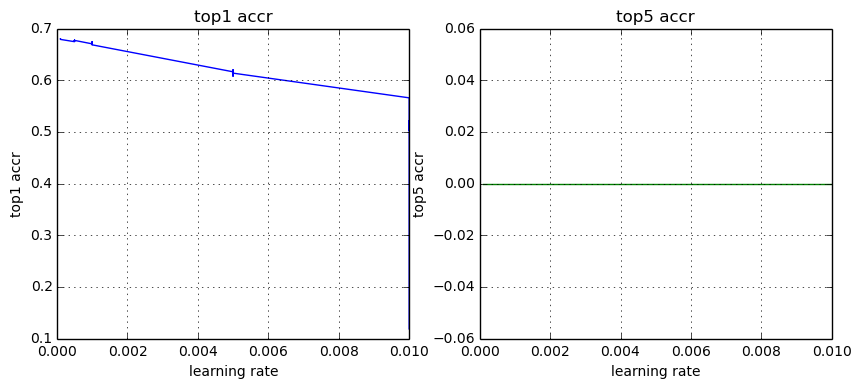

In [211]:
#plot learning rate - accuracy ---- EXPERIMENTING
plt.figure(1,figsize=(10, 4))
plt.subplot(121)
plt.title('top1 accr')
plt.plot(result_tbls[0]['test_result'][1,:],result_tbls[0]['test_result'][3,:])
plt.grid(True)
plt.xlabel('learning rate')
plt.ylabel('top1 accr')
plt.subplot(122)
plt.title('top5 accr')
plt.plot(result_tbls[0]['test_result'][1,:],result_tbls[0]['test_result'][4,:],color='green')
plt.grid(True)
plt.xlabel('learning rate')
plt.ylabel('top5 accr')

In [212]:
#### formattings
def plot_formats(num):
    #from itertools import cycle
    #lines = ["-","--"]
    #linecycler = cycle(lines)    
    lwidths = np.linspace(1,4,num)
    formats = [{'lw':lw} for lw in lwidths]
    return formats

TEST MAX ACCURACY: 512-original
maxiter_top1 =  78650.0 top1acc = 0.6802 top5acc = 0.0
maxiter_top5 =  1430.0 top1acc = 0.1186 top5acc = 0.0
total of epochs run: 55
TEST MAX ACCURACY: 512-triangular2-t2
No test log available yet.


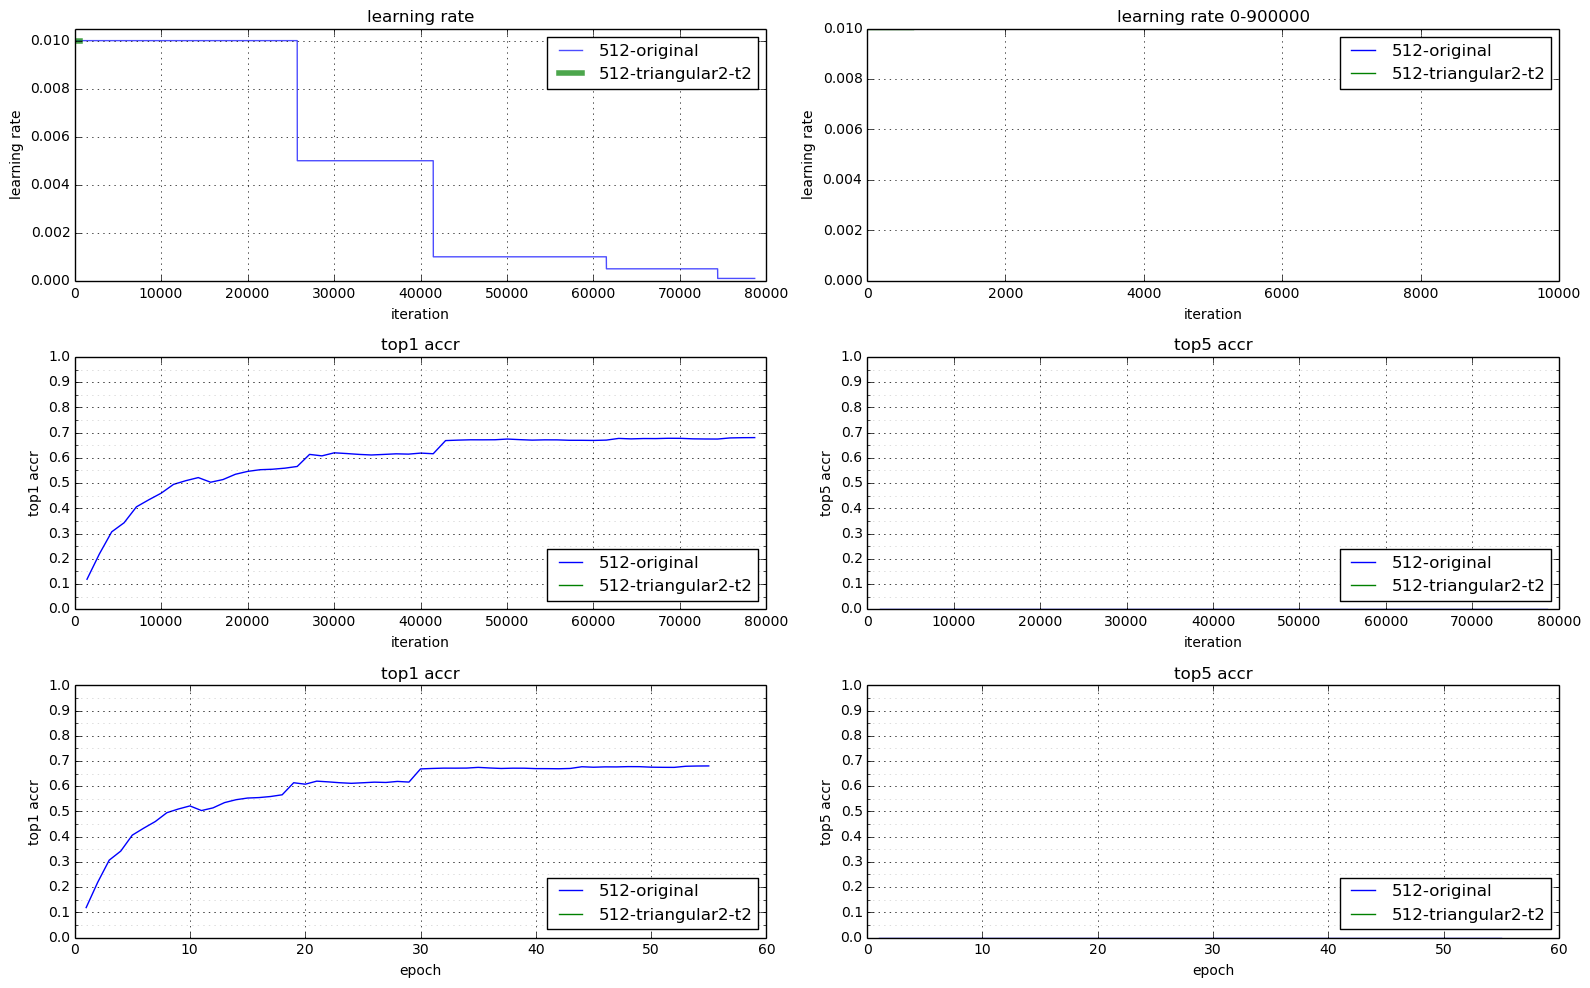

In [222]:
lineformats = plot_formats(len(result_tbls))
#plot the learning curve of one epoch
plt.figure(1,figsize=(16,10))

major_ticks = np.arange(0, 1.01, 0.1)                                              
minor_ticks = np.arange(0, 1.01, 0.05)
#plot the error
ax=plt.subplot(321)
plt.title('learning rate')
ymax = 0
for result,lineformat in zip(result_tbls,lineformats):
    ymax = max(ymax,max(result['train_result'][1,:]))
    plt.plot(result['train_result'][0,:],result['train_result'][1,:],label=result['label'],linewidth=lineformat['lw'],alpha=0.7)
ax.legend(loc='upper right')
plt.grid(True)
plt.xlabel('iteration')
plt.ylabel('learning rate')
plt.ylim((0,1.05*ymax))

ax=plt.subplot(322)
plt.title('learning rate 0-900000')
for result in result_tbls:
    plt.plot(result['train_result'][0,:],result['train_result'][1,:],label=result['label'])
ax.legend(loc='upper right')
plt.grid(True)
plt.xlabel('iteration')
plt.ylabel('learning rate')
plt.xlim((0,10000))       

#plot the accuracies
ax=plt.subplot(323)                                          
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('top1 accr')
for result in result_tbls:
    plt.plot(result['test_result'][0,:],result['test_result'][3,:],label=result['label'])
ax.legend(loc='lower right')
plt.grid(True)
plt.ylim((0,1))
plt.xlabel('iteration')
plt.ylabel('top1 accr')

#plot the accuracies
ax=plt.subplot(324)
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('top5 accr')
for result in result_tbls:
    plt.plot(result['test_result'][0,:],result['test_result'][4,:],label=result['label'])
ax.legend(loc='lower right')
plt.grid(True)
plt.ylim((0,1))
plt.xlabel('iteration')
plt.ylabel('top5 accr')
         
#plot the accuracies
ax=plt.subplot(325)                                          
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('top1 accr')
for result in result_tbls:
    plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][3,:],label=result['label'])
ax.legend(loc='lower right')
plt.grid(True)
plt.ylim((0,1))
plt.xlabel('epoch')
plt.ylabel('top1 accr')

#plot the accuracies
ax=plt.subplot(326)
ax.set_yticks(major_ticks)                                                       
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)                                                
plt.title('top5 accr')
for result in result_tbls:
    plt.plot(result['test_result_epoch'][0,:],result['test_result_epoch'][4,:],label=result['label'])
ax.legend(loc='lower right')
plt.grid(True)
plt.ylim((0,1))
plt.xlabel('epoch')
plt.ylabel('top5 accr')
plt.tight_layout()

for result in result_tbls:
    print 'TEST MAX ACCURACY:',result['label']
    if len(result['test_result'][1]) == 0:
        print "No test log available yet." 
        continue
    am = result['test_result'].max(axis=1)
    maxind = result['test_result'].argmax(axis=1)
    print 'maxiter_top1 = ',result['test_result'][0,maxind[3]],'top1acc =',result['test_result'][3,maxind[3]],'top5acc =',result['test_result'][4,maxind[3]]
    print 'maxiter_top5 = ',result['test_result'][0,maxind[4]],'top1acc =',result['test_result'][3,maxind[4]],'top5acc =',result['test_result'][4,maxind[4]]
    print 'total of epochs run:',result['test_result'].shape[1]